
```
Sets up a DistilBERT model for IMDB sentiment classification, freezes the encoder layers for 'head-only' training, and compares the performance of OscillatingLR, AdamW, SGD, and RMSprop optimizers. It includes gradient accumulation and logs the last 30 steps' learning rates and losses for comparison.
```


In [7]:
import pandas as pd
import os

# Construct full CSV file path /content/IMDB Dataset.csv
csv_path = "/content/IMDB Dataset.csv"

# Load the CSV using pandas
df = pd.read_csv(csv_path)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


✅ Device: cpu
📦 Dataset: (5000, 2)
🧾 MAX_LEN=128 | Train batches=250 | Test batches=63

🚀 Training head-only with OscillatingLR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OscillatingLR | Epoch 1/3 | loss 0.6879 | acc 55.23%
OscillatingLR | Epoch 2/3 | loss 0.6645 | acc 64.03%
OscillatingLR | Epoch 3/3 | loss 0.6361 | acc 70.30%

🚀 Training head-only with AdamW


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdamW | Epoch 1/3 | loss 0.6936 | acc 50.88%
AdamW | Epoch 2/3 | loss 0.6930 | acc 51.67%
AdamW | Epoch 3/3 | loss 0.6937 | acc 50.80%

🚀 Training head-only with SGD


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SGD | Epoch 1/3 | loss 0.6927 | acc 51.25%
SGD | Epoch 2/3 | loss 0.6925 | acc 50.70%
SGD | Epoch 3/3 | loss 0.6923 | acc 52.23%

🚀 Training head-only with RMSprop


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RMSprop | Epoch 1/3 | loss 0.6969 | acc 48.55%
RMSprop | Epoch 2/3 | loss 0.6975 | acc 47.30%
RMSprop | Epoch 3/3 | loss 0.6970 | acc 47.33%


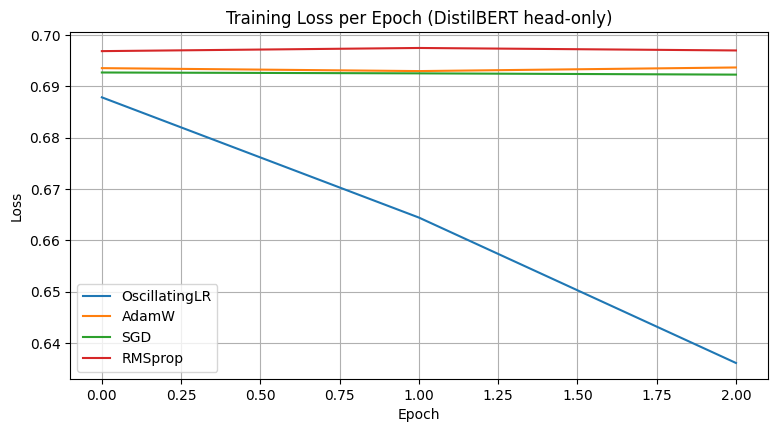

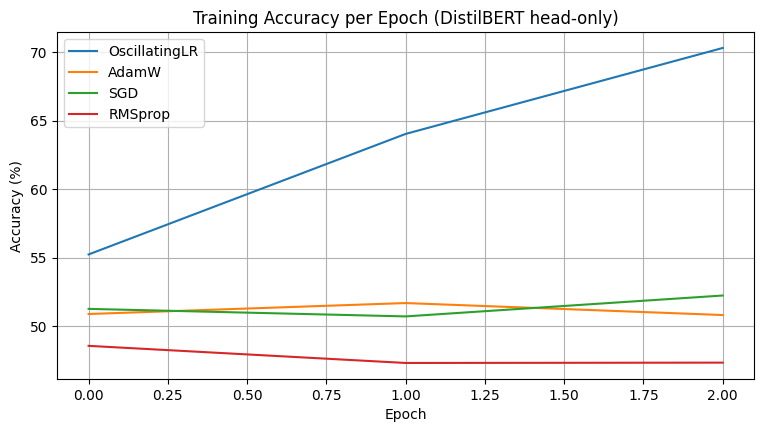

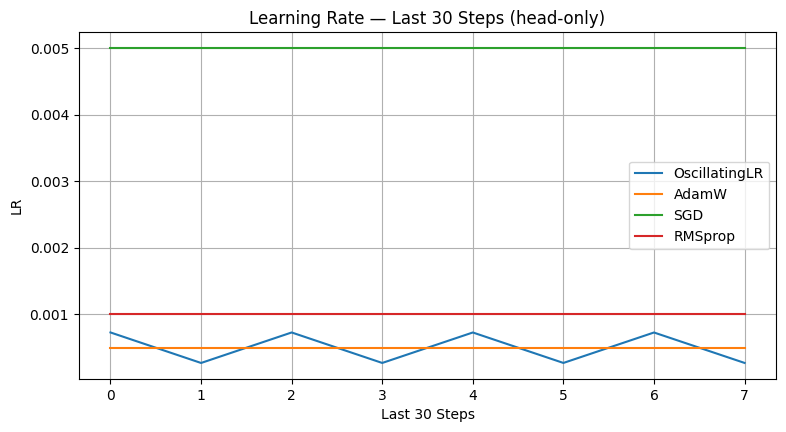

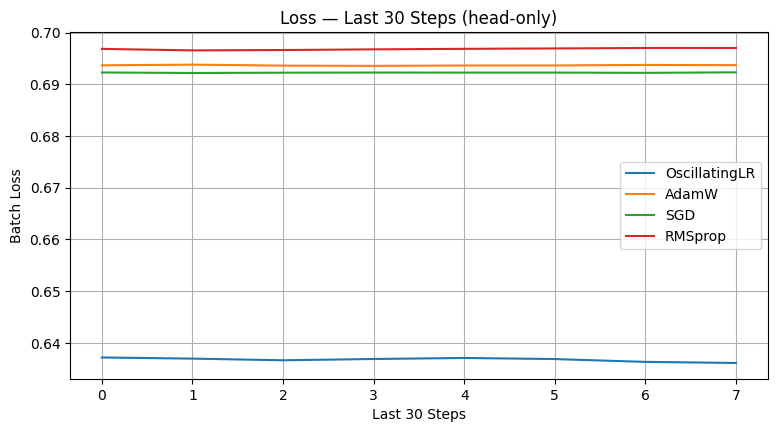


🏁 Final Test Accuracy:
OscillatingLR: 73.90%
AdamW: 51.80%
SGD: 52.70%
RMSprop: 49.60%


In [10]:
# ============================================================
# IMDB Sentiment (5k balanced) — DistilBERT (CPU Turbo)
# Classifier-only training (encoder frozen)
# Optimizer comparison: OscillatingLR vs AdamW vs SGD vs RMSprop
# Logs last 30 steps (LR + Loss) and plots LR/Loss comparisons
# ============================================================

import os, re, random, math, time, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ---------- install transformers if missing ----------
try:
    import transformers
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers==4.44.2", "accelerate>=0.33.0"])
    import transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ----------------------------
# Load IMDB CSV (Kaggle path), sample 5k (2.5k+2.5k)
# ----------------------------

# Construct full CSV file path /content/IMDB Dataset.csv
csv_path = "/content/IMDB Dataset.csv"
assert os.path.exists(csv_path), "IMDB CSV not found at given path."

df_full = pd.read_csv(csv_path)
df_pos = df_full[df_full["sentiment"]=="positive"].sample(2500, random_state=42)
df_neg = df_full[df_full["sentiment"]=="negative"].sample(2500, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print("📦 Dataset:", df.shape)

# ----------------------------
# Clean text (keep apostrophes for contractions)
# ----------------------------
_tok_re = re.compile(r"[^a-zA-Z\s']+")
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = _tok_re.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["clean"] = df["review"].fillna("").apply(clean_text)
labels_np = (df["sentiment"] == "positive").astype(int).values  # 1=pos, 0=neg

# ----------------------------
# Tokenize (fast), shorter seq for CPU
# ----------------------------
MAX_LEN = 128
BATCH = 16
ACC_STEPS = 4  # gradient accumulation (effective batch = 64)
EPOCHS = 3     # CPU-friendly; increase if time allows

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc = tokenizer(
    df["clean"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="pt"
)
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]
labels_t = torch.tensor(labels_np, dtype=torch.long)

# ----------------------------
# Dataset & Dataloaders
# ----------------------------
class IMDBBertDS(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids; self.mask = mask; self.labels = labels
    def __len__(self):
        return self.ids.size(0)
    def __getitem__(self, i):
        return {
            "input_ids": self.ids[i],
            "attention_mask": self.mask[i],
            "labels": self.labels[i]
        }

dataset = IMDBBertDS(input_ids, attention_mask, labels_t)
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

print(f"🧾 MAX_LEN={MAX_LEN} | Train batches={len(train_loader)} | Test batches={len(test_loader)}")

# ----------------------------
# Model factory (freeze encoder — classifier-only training)
# ----------------------------
def make_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )
    # freeze the encoder
    for p in model.distilbert.parameters():
        p.requires_grad = False
    # Typically train pre_classifier, dropout, and classifier
    trainable = []
    for p in model.pre_classifier.parameters():
        p.requires_grad = True; trainable.append(p)
    for p in model.classifier.parameters():
        p.requires_grad = True; trainable.append(p)
    # (dropout has no params)
    return model.to(device)

def get_trainable_params(model):
    params = []
    params += list(model.pre_classifier.parameters())
    params += list(model.classifier.parameters())
    return params

# ----------------------------
# Custom OscillatingLR (gentle; head-only)
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=5e-4, oscillation_factor=2.5e-4, momentum=0.98, decay=5e-4):
        self.base_lr, self.osc, self.momentum = base_lr, oscillation_factor, momentum
        self.decay, self.step_count = decay, 0
        super().__init__(params, dict(momentum=momentum))
        for g in self.param_groups:
            for p in g['params']:
                self.state[p] = {'velocity': torch.zeros_like(p)}

    def step(self, closure=None):
        self.step_count += 1
        decay = 1.0 / (1.0 + self.decay * self.step_count)
        lr = self.base_lr + self.osc * decay * (1 if self.step_count % 2 == 0 else -1)
        for g in self.param_groups:
            m = g['momentum']
            for p in g['params']:
                if p.grad is not None:
                    v = self.state[p]['velocity']
                    v.mul_(m).add_(p.grad)
                    p.data -= lr * v
                    self.state[p]['velocity'] = v
        return lr

# ----------------------------
# Train / Eval (with gradient accumulation & last-30-steps logging)
# ----------------------------
def train_one(model, optimizer, epochs=EPOCHS, name="OPT"):
    model.train()
    loss_hist, acc_hist = [], []
    ce = nn.CrossEntropyLoss()

    steps_per_epoch = len(train_loader)
    total_steps = epochs * steps_per_epoch
    step_global = 0
    last30_logs = []

    optimizer_is_osc = isinstance(optimizer, OscillatingLR)

    for ep in range(epochs):
        running_loss = correct = total = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            step_global += 1

            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)

            out = model(**inputs)
            loss = ce(out.logits, y) / ACC_STEPS
            loss.backward()

            # Gradient accumulation update
            lr_val = None
            if (i + 1) % ACC_STEPS == 0 or (i + 1) == steps_per_epoch:
                lr_val = optimizer.step() if optimizer_is_osc else optimizer.param_groups[0]['lr']
                optimizer.zero_grad()

            running_loss += float(loss.item()) * ACC_STEPS  # unscale for logging
            pred = out.logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # Log last 30 global steps (based on optimizer updates)
            # Only log when an optimizer step actually happened (after accumulation)
            if lr_val is not None and step_global > (total_steps - 30):
                last30_logs.append({"step": step_global, "lr": float(lr_val), "loss": float(running_loss/(i+1))})

        ep_loss = running_loss / steps_per_epoch
        ep_acc  = 100 * correct / total
        loss_hist.append(ep_loss); acc_hist.append(ep_acc)
        print(f"{name} | Epoch {ep+1}/{epochs} | loss {ep_loss:.4f} | acc {ep_acc:.2f}%")

    return loss_hist, acc_hist, last30_logs

@torch.no_grad()
def evaluate(model):
    model.eval()
    total = correct = 0
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        y = batch["labels"].to(device)
        out = model(**inputs)
        pred = out.logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100 * correct / total

# ----------------------------
# Build + run all optimizers (head-only params)
# ----------------------------
def make_optimizer(name, params):
    if name == "OscillatingLR":
        return OscillatingLR(params, base_lr=5e-4, oscillation_factor=2.5e-4, momentum=0.98, decay=5e-4)
    if name == "AdamW":
        return optim.AdamW(params, lr=5e-4)  # head-only can afford higher LR
    if name == "SGD":
        return optim.SGD(params, lr=5e-3, momentum=0.9)
    if name == "RMSprop":
        return optim.RMSprop(params, lr=1e-3)
    raise ValueError(name)

optimizers_to_try = ["OscillatingLR", "AdamW", "SGD", "RMSprop"]

results = {}
last30 = {}

for opt_name in optimizers_to_try:
    print("\n" + "="*68)
    print(f"🚀 Training head-only with {opt_name}")
    model = make_model()
    head_params = get_trainable_params(model)
    optimizer = make_optimizer(opt_name, head_params)
    losses, accs, logs = train_one(model, optimizer, epochs=EPOCHS, name=opt_name)
    test_acc = evaluate(model)
    results[opt_name] = {"loss": losses, "acc": accs, "test": test_acc}
    last30[opt_name] = logs

# ----------------------------
# Plots: Loss/Acc per epoch
# ----------------------------
plt.figure(figsize=(9,4.5))
for name in results: plt.plot(results[name]["loss"], label=name)
plt.title("Training Loss per Epoch (DistilBERT head-only)"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(9,4.5))
for name in results: plt.plot(results[name]["acc"], label=name)
plt.title("Training Accuracy per Epoch (DistilBERT head-only)"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True); plt.show()

# ----------------------------
# Last-30: LR comparison (Oscillating zig-zag + flat for others)
# ----------------------------
plt.figure(figsize=(9,4.5))
for name, logs in last30.items():
    lrs = [d["lr"] for d in logs]
    if len(lrs) > 0:
        plt.plot(range(len(lrs)), lrs, label=name)
plt.title("Learning Rate — Last 30 Steps (head-only)"); plt.xlabel("Last 30 Steps"); plt.ylabel("LR"); plt.legend(); plt.grid(True); plt.show()

# ----------------------------
# Last-30: Loss comparison
# ----------------------------
plt.figure(figsize=(9,4.5))
for name, logs in last30.items():
    losses_ = [d["loss"] for d in logs]
    if len(losses_) > 0:
        plt.plot(range(len(losses_)), losses_, label=name)
plt.title("Loss — Last 30 Steps (head-only)"); plt.xlabel("Last 30 Steps"); plt.ylabel("Batch Loss"); plt.legend(); plt.grid(True); plt.show()

print("\n🏁 Final Test Accuracy:")
for name in results:
    print(f"{name}: {results[name]['test']:.2f}%")

Optimizer comparison for DistilBERT head-only training. This time, it uses an equal learning rate (1e-3) for all optimizers and provides more detailed per-step logging of loss and learning rate for granular analysis.

In [9]:
# ============================================================
# Fixed: IMDB 5k balanced sample + DistilBERT head-only
# Equal LR comparison (1e-3) with per-step logging (every step)
# Optimizers: OscillatingLR, AdamW, SGD, RMSprop
# ============================================================

import os, re, random, sys, subprocess, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Install transformers if missing
try:
    import transformers
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers==4.44.2", "accelerate>=0.33.0"])
    import transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

✅ Device: cpu


In [11]:
# ----------------------------
# Load IMDB (Kaggle) and sample 5k (2.5k pos + 2.5k neg)
# ----------------------------
kaggle_path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews"
csv_file_path = os.path.join(kaggle_path, "IMDB Dataset.csv")
if not os.path.exists(csv_file_path):
    raise FileNotFoundError(f"IMDB CSV not found at: {csv_file_path}")

df_full = pd.read_csv(csv_file_path)

# Ensure expected columns exist
assert "review" in df_full.columns and "sentiment" in df_full.columns, "CSV must contain 'review' and 'sentiment' columns"

# Count available positives/negatives
pos_count = (df_full["sentiment"] == "positive").sum()
neg_count = (df_full["sentiment"] == "negative").sum()
print(f"Available samples: pos={pos_count}, neg={neg_count}")

# Desired per-class sample
per_class = 2500
if pos_count < per_class or neg_count < per_class:
    raise ValueError(f"Not enough samples to form {per_class}+{per_class}. Found pos={pos_count}, neg={neg_count}")

df_pos = df_full[df_full["sentiment"] == "positive"].sample(per_class, random_state=42)
df_neg = df_full[df_full["sentiment"] == "negative"].sample(per_class, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print("📦 Sampled dataset shape:", df.shape)

# ----------------------------
# Clean text (keep apostrophes)
# ----------------------------
_tok_re = re.compile(r"[^a-zA-Z\s']+")
def clean_text(t):
    t = str(t).lower()
    t = _tok_re.sub(" ", t)
    return re.sub(r"\s+", " ", t).strip()

df["clean"] = df["review"].fillna("").apply(clean_text)
labels_np = (df["sentiment"] == "positive").astype(int).values

# ----------------------------
# Tokenize (shorter seq for CPU)
# ----------------------------
MAX_LEN = 128
BATCH = 16
EPOCHS = 3

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc = tokenizer(df["clean"].tolist(), truncation=True, padding="max_length",
                max_length=MAX_LEN, return_tensors="pt")

class IMDBBertDS(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids, self.mask, self.labels = ids, mask, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {"input_ids": self.ids[i],
                "attention_mask": self.mask[i],
                "labels": self.labels[i]}

dataset = IMDBBertDS(enc["input_ids"], enc["attention_mask"], torch.tensor(labels_np))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

print(f"🧾 Train batches={len(train_loader)} | Test batches={len(test_loader)}")

# ----------------------------
# Model factory (encoder frozen)
# ----------------------------
def make_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    )
    for p in model.distilbert.parameters():
        p.requires_grad = False
    # Ensure classifier/pre_classifier are trainable
    for p in model.pre_classifier.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True
    return model.to(device)

def get_trainable_params(model):
    return list(model.pre_classifier.parameters()) + list(model.classifier.parameters())

# ----------------------------
# OscillatingLR (same LR base)
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=1e-3, oscillation_factor=5e-4, momentum=0.98, decay=5e-4):
        self.base_lr, self.osc, self.momentum = base_lr, oscillation_factor, momentum
        self.decay, self.step_count = decay, 0
        super().__init__(params, dict(momentum=momentum))
        for g in self.param_groups:
            for p in g['params']:
                self.state[p] = {'velocity': torch.zeros_like(p)}
    def step(self, closure=None):
        self.step_count += 1
        decay = 1/(1 + self.decay * self.step_count)
        lr = self.base_lr + self.osc * decay * (1 if self.step_count % 2 == 0 else -1)
        for g in self.param_groups:
            m = g['momentum']
            for p in g['params']:
                if p.grad is not None:
                    v = self.state[p]['velocity']
                    v.mul_(m).add_(p.grad)
                    p.data -= lr * v
                    self.state[p]['velocity'] = v
        return lr

# ----------------------------
# Train & eval with per-step logging
# ----------------------------
def train_eval(name, optimizer_class, lr=1e-3):
    model = make_model()
    params = get_trainable_params(model)
    # instantiate optimizer
    if optimizer_class == OscillatingLR:
        optimizer = optimizer_class(params, base_lr=lr)
    else:
        # AdamW accepts lr keyword; for other built-ins, this works too
        optimizer = optimizer_class(params, lr=lr)

    ce = nn.CrossEntropyLoss()
    logs = []
    step = 0

    for epoch in range(EPOCHS):
        model.train()
        for i, batch in enumerate(train_loader):
            step += 1
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)

            optimizer.zero_grad()
            out = model(**inputs)
            loss = ce(out.logits, y)
            loss.backward()

            # step
            if isinstance(optimizer, OscillatingLR):
                lr_now = optimizer.step()
            else:
                optimizer.step()
                lr_now = optimizer.param_groups[0]["lr"]

            logs.append({"step": step, "epoch": epoch+1, "loss": float(loss.item()), "lr": float(lr_now)})

            # optional console progress
            if step % 25 == 0:
                print(f"{name} | Step {step:04d} | Epoch {epoch+1} | Loss {loss.item():.4f} | LR {lr_now:.6f}")

    # evaluation
    model.eval(); correct=total=0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)
            out = model(**inputs)
            pred = out.logits.argmax(dim=1)
            correct += (pred==y).sum().item(); total += y.size(0)
    acc = 100 * correct / total
    print(f"\n✅ {name} Test Accuracy: {acc:.2f}%\n")
    return pd.DataFrame(logs), acc

# ----------------------------
# Run all optimizers with equal LR
# ----------------------------
optimizers = {
    "OscillatingLR": OscillatingLR,
    "AdamW": optim.AdamW,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop
}

logs_all = {}
accs = {}
for name, opt_class in optimizers.items():
    print("\n" + "="*70)
    print(f"🚀 Training with {name} (lr=1e-3)")
    df_logs, acc = train_eval(name, opt_class, lr=1e-3)
    logs_all[name] = df_logs
    accs[name] = acc

# ----------------------------
# Plots: per-step loss & LR
# ----------------------------
plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["loss"], label=name, alpha=0.9)
plt.title("Per-step Loss (equal LR = 1e-3)"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["lr"], label=name, alpha=0.9)
plt.title("Per-step Learning Rate (equal LR = 1e-3)"); plt.xlabel("Step"); plt.ylabel("LR"); plt.legend(); plt.grid(True); plt.show()

print("\n🏁 Final Test Accuracies:")
for name, acc in accs.items():
    print(f"{name}: {acc:.2f}%")

FileNotFoundError: IMDB CSV not found at: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv